In [ ]:
from torch.utils.data import DataLoader
import torch
from transformers import BertForSequenceClassification
from torch.optim import AdamW

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import Dataset
from google.colab import files

from google.colab import files


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import os

from transformers import BertTokenizer

import shutil

from google.colab import drive

In [ ]:
def load_data(data_path):
    data = pd.read_csv(data_path)

    # df = data.groupby('label').apply(lambda x: x.sample(n=2000, random_state=42)).reset_index(drop=True)

    return train_test_split(data, train_size=0.8, stratify=data['label'])

def tokenize_data(train_data, test_data):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_encodings = tokenizer(list(train_data['text']), padding=True, truncation=True, max_length=128)
    test_encodings = tokenizer(list(test_data['text']), padding=True, truncation=True, max_length=128)
    return train_encodings, test_encodings

def get_tokenizer():
    return BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


In [ ]:
dataset = files.upload()

Saving emotions.csv to emotions.csv


In [ ]:
dataset_path = 'emotions.csv'

train_df, test_df = load_data(dataset_path)

train_enc, test_enc = tokenize_data(train_df, test_df)

train_dataset = TextDataset(train_enc, train_df['label'].tolist())
test_dataset = TextDataset(test_enc, test_df['label'].tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

<ipython-input-3-538c1437a5f1>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = data.groupby('label').apply(lambda x: x.sample(n=2000, random_state=42)).reset_index(drop=True)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
print(train_df.head())
print(test_df.head())

                                                    text  label
11909           i feel so strange so completely unafraid      5
634    i believe getting credit for doing a good deed...      0
10111  i sat for hours and im feeling a bit weird my ...      5
116                               i feel im unsuccessful      0
10807  i happen to enjoy immensely plus she s from at...      5
                                                   text  label
2150  i really do understand why some of you keep yo...      1
1748  i start thinking of packing i feel a little ho...      0
6939  i untagged comments open pings open y m d h sl...      3
8760  i feel hesitant making copies of it and distri...      4
6797  i did not feel as if i had an injury that coul...      3


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)
model.to(device)


optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} complete! Avg loss: {avg_loss:.4f}")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 complete! Avg loss: 0.6617
Epoch 2 complete! Avg loss: 0.1882
Epoch 3 complete! Avg loss: 0.1308



Accuracy: 0.9363

Classification Report:
              precision    recall  f1-score   support

           0     0.9596    0.9500    0.9548       400
           1     0.9916    0.8900    0.9381       400
           2     0.9106    0.9925    0.9498       400
           3     0.9464    0.9275    0.9369       400
           4     0.9178    0.8650    0.8906       400
           5     0.9023    0.9925    0.9452       400

    accuracy                         0.9363      2400
   macro avg     0.9380    0.9362    0.9359      2400
weighted avg     0.9380    0.9363    0.9359      2400



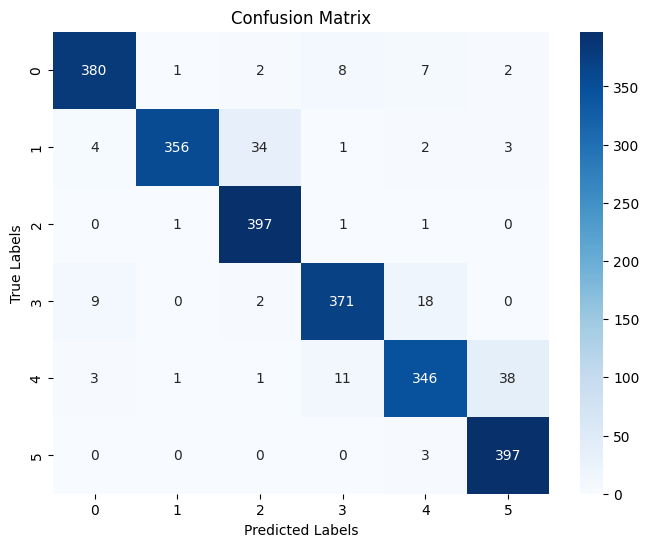

In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 1. Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"\nAccuracy: {acc:.4f}")

# 2–5. Precision, Recall, F1-Score, Support
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# 6. Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
# model.save_pretrained("bert_model")
# tokenizer = get_tokenizer()
# tokenizer.save_pretrained("bert_model")

# shutil.make_archive("bert_model", 'zip', "bert_model")

# from google.colab import files
# files.download("bert_model.zip")

In [ ]:
# Step 1: Create a folder to save the model
model_path = "bert_emotion_model"
os.makedirs(model_path, exist_ok=True)  # ✅ create the directory if it doesn't exist

# Step 2: Save the model weights
torch.save(model.state_dict(), f"{model_path}/pytorch_model.bin")

# Step 3: Save the tokenizer and config
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer.save_pretrained(model_path)

# Also save the model config (if you're using BertForSequenceClassification)
model.config.save_pretrained(model_path)

shutil.make_archive(model_path, 'zip', model_path)

files.download(f"{model_path}.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

dataset_path = '/content/drive/My Drive/University/Bachelor/FinalProject/emotions.csv'

df = pd.read_csv(dataset_path)
print(df.head())

                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4
